# Libraries/Dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import matplotlib.patches as mpatches

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


# Simulated Annealing Parameters

In [7]:
# Parameters for simulated annealing
initial_temperature = 1000
cooling_rate = 0.8
min_temperature = 1
iterations_per_temp = 10
export_name = "best_schedule6.csv"

# Functions

## Main

In [3]:
# Main function to run the simulation and export the results
def main():
    # Create an initial schedule
    initial_schedule = initial_solution(df_BOM)
    print("Initial Schedule:", initial_schedule)
    # Test the revised evaluation function with machine availability
    initial_makespan, initial_usage = calculate_makespan(initial_schedule, df_BOM, df_machine)
    print("Initial Makespan with Machine Availability:", initial_makespan)

    # Run the simulated annealing algorithm
    best_schedule, best_makespan = simulated_annealing(df_BOM, initial_schedule, initial_temperature, cooling_rate, min_temperature, iterations_per_temp)
    print("Best Schedule:", best_schedule)
    print("Best Makespan:", best_makespan)

    # Generate the Gantt chart for the best schedule
    generate_detailed_gantt_chart(best_schedule, df_BOM, best_makespan, df_machine)
    generate_beautified_gantt_chart(best_schedule, df_BOM, df_machine)

    # Export the best schedule to CSV
    export_schedule_to_csv(best_schedule, df_BOM, df_machine, export_name)
    
# Initial solution respecting precedence constraints
def initial_solution(df_BOM):
    schedule = []
    remaining_operations = set(df_BOM['operation'].tolist())
    
    while remaining_operations:
        for op in list(remaining_operations):
            predecessors = df_BOM[df_BOM['operation'] == op]['predecessor_operations'].values[0]
            if all(pred in schedule for pred in predecessors):
                schedule.append(op)
                remaining_operations.remove(op)
    
    return schedule

# Calculate makespan of a schedule
def calculate_makespan(schedule, df_BOM, df_machine):
    end_times = {}
    machine_availability = {
        workcenter: {machine: [0] * df_machine.loc[df_machine['workcenter'] == workcenter, machine].values[0]
                     for machine in df_machine.columns if machine != 'workcenter'}
        for workcenter in df_machine['workcenter']
    }
    workcenter_machine_usage = {
        workcenter: {machine: [] for machine in df_machine.columns if machine != 'workcenter'}
        for workcenter in df_machine['workcenter']
    }

    for op in schedule:
        machine = df_BOM[df_BOM['operation'] == op]['machine'].values[0]
        workcenter = df_BOM[df_BOM['operation'] == op]['workcenter'].values[0]
        processing_time = df_BOM[df_BOM['operation'] == op]['processing_time'].values[0]
        predecessors = df_BOM[df_BOM['operation'] == op]['predecessor_operations'].values[0]

        # Calculate the earliest start time considering both predecessors and machine availability
        start_time = max([end_times.get(pred, 0) for pred in predecessors], default=0)
        
        # Find the earliest available machine in the workcenter
        earliest_machine_idx = min(range(len(machine_availability[workcenter][machine])), key=lambda x: machine_availability[workcenter][machine][x])
        start_time = max(start_time, machine_availability[workcenter][machine][earliest_machine_idx])

        # Calculate the end time of the operation
        end_time = start_time + processing_time
        end_times[op] = end_time

        # Update the machine availability and usage
        machine_availability[workcenter][machine][earliest_machine_idx] = end_time
        workcenter_machine_usage[workcenter][machine].append((start_time, end_time, op, earliest_machine_idx))

    return max(end_times.values()), workcenter_machine_usage

# Check if a schedule adheres to the precedence constraints
def check_precedence_constraints(schedule, df_BOM):
    operation_positions = {op: idx for idx, op in enumerate(schedule)}
    for op in schedule:
        predecessors = df_BOM[df_BOM['operation'] == op]['predecessor_operations'].values[0]
        if any(operation_positions[pred] >= operation_positions[op] for pred in predecessors):
            return False
    return True

# Generate a neighbor solution by swapping two operations
def generate_neighbor(schedule, df_BOM):
    new_schedule = schedule[:]
    while True:
        idx1, idx2 = random.sample(range(len(schedule)), 2)
        new_schedule[idx1], new_schedule[idx2] = new_schedule[idx2], new_schedule[idx1]
        if check_precedence_constraints(new_schedule, df_BOM):
            break
        else:
            new_schedule = schedule[:]
    return new_schedule

# Determine if a new solution should be accepted
def accept_solution(current_makespan, new_makespan, temperature):
    if new_makespan < current_makespan:
        return True
    else:
        prob = np.exp((current_makespan - new_makespan) / temperature)
        return random.random() < prob

# Simulated Annealing Algorithm
def simulated_annealing(df_BOM, initial_schedule, initial_temperature, cooling_rate, min_temperature, iterations_per_temp):
    current_schedule = initial_schedule
    current_makespan, _ = calculate_makespan(current_schedule, df_BOM, df_machine)
    best_schedule = current_schedule
    best_makespan = current_makespan
    temperature = initial_temperature
    print(temperature)
    while temperature > min_temperature:
        for _ in range(iterations_per_temp):
            new_schedule = generate_neighbor(current_schedule, df_BOM)
            new_makespan, _ = calculate_makespan(new_schedule, df_BOM, df_machine)
            
            if check_precedence_constraints(new_schedule, df_BOM) and accept_solution(current_makespan, new_makespan, temperature):
                current_schedule = new_schedule
                current_makespan = new_makespan
                
                if new_makespan < best_makespan:
                    best_schedule = new_schedule
                    best_makespan = new_makespan
        print(temperature)
        temperature *= cooling_rate
    
    return best_schedule, best_makespan

## Gantt Chart

In [4]:
def generate_detailed_gantt_chart(schedule, df_BOM, total_makespan, df_machine):
    _, workcenter_machine_usage = calculate_makespan(schedule, df_BOM, df_machine)

    # Generate colors for each machine-workcenter combination
    unique_machines = df_BOM['machine'].unique()
    unique_workcenters = df_BOM['workcenter'].unique()
    color_palette = plt.cm.get_cmap('tab20', len(unique_machines) * len(unique_workcenters))
    color_index = 0
    colors = {}
    for wc in unique_workcenters:
        for machine in unique_machines:
            colors[(wc, machine)] = color_palette(color_index)
            color_index += 1

    # Plot the Gantt chart
    fig, ax = plt.subplots(figsize=(15, 10))

    y_ticks = []
    y_labels = []
    y_position = 0

    for wc in df_machine['workcenter']:
        for machine in df_machine.columns:
            if machine != 'workcenter':
                num_machines = df_machine.loc[df_machine['workcenter'] == wc, machine].values[0]
                for machine_idx in range(num_machines):
                    if (wc in workcenter_machine_usage) and (machine in workcenter_machine_usage[wc]):
                        for (start, end, op, used_machine_idx) in workcenter_machine_usage[wc][machine]:
                            if used_machine_idx == machine_idx:
                                ax.broken_barh([(start, end - start)], (y_position - 0.4, 0.8), facecolors=(colors[(wc, machine)]))
                                ax.text(start, y_position, f" {op} ({machine}-{machine_idx + 1})", va='center', ha='left')

                    y_ticks.append(y_position)
                    y_labels.append(f"{wc} {machine}-{machine_idx + 1}")
                    y_position += 1

    ax.set_yticks(y_ticks)
    ax.set_yticklabels(y_labels)
    ax.set_xlabel('Time')
    ax.set_ylabel('Machine - Workcenter')
    ax.grid(True)

    # Ensure the x-axis matches the total makespan
    ax.set_xlim(0, total_makespan)

    # Create a legend for the color-coded machine and workcenter
    legend_patches = [mpatches.Patch(color=colors[(wc, machine)], label=f'{wc} - {machine}')
                      for wc in unique_workcenters for machine in unique_machines]
    ax.legend(handles=legend_patches, bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.show()


def generate_beautified_gantt_chart(schedule, df_BOM, df_machine):
    schedule_data = []
    operation_end_times = {}
    machine_availability = {
        workcenter: {machine: [0] * df_machine.loc[df_machine['workcenter'] == workcenter, machine].values[0]
                     for machine in df_machine.columns if machine != 'workcenter'}
        for workcenter in df_machine['workcenter']
    }

    # Define a light color palette for each workcenter
    unique_workcenters = df_BOM['workcenter'].unique()
    color_palette = plt.cm.get_cmap('Pastel1', len(unique_workcenters))
    workcenter_colors = {workcenter: color_palette(i) for i, workcenter in enumerate(unique_workcenters)}

    for op in schedule:
        machine = df_BOM[df_BOM['operation'] == op]['machine'].values[0]
        workcenter = df_BOM[df_BOM['operation'] == op]['workcenter'].values[0]
        processing_time = df_BOM[df_BOM['operation'] == op]['processing_time'].values[0]
        predecessors = df_BOM[df_BOM['operation'] == op]['predecessor_operations'].values[0]

        # Calculate the earliest start time considering predecessors
        start_time = max([operation_end_times.get(pred, 0) for pred in predecessors], default=0)
        
        # Find the earliest available machine in the workcenter
        earliest_machine_idx = min(range(len(machine_availability[workcenter][machine])), key=lambda x: machine_availability[workcenter][machine][x])
        start_time = max(start_time, machine_availability[workcenter][machine][earliest_machine_idx])

        # Calculate the end time of the operation
        end_time = start_time + processing_time
        schedule_data.append({
            'Operation': op,
            'Start': start_time,
            'End': end_time,
            'Machine': machine,
            'Workcenter': workcenter,
            'Color': workcenter_colors[workcenter],
            'MachineIdx': earliest_machine_idx + 1
        })

        # Update the availability time for the machine in the workcenter
        machine_availability[workcenter][machine][earliest_machine_idx] = end_time
        operation_end_times[op] = end_time

    # Convert schedule data to DataFrame for plotting
    df_schedule = pd.DataFrame(schedule_data)

    # Plot the Gantt chart
    fig, ax = plt.subplots(figsize=(15, 10))

    for idx, row in df_schedule.iterrows():
        ax.broken_barh(
            [(row['Start'], row['End'] - row['Start'])],
            (idx - 0.4, 0.8),
            facecolors=(row['Color'])
        )
        ax.text(
            row['Start'] + 0.1,
            idx,
            f"{row['Operation']} ({row['Machine']}-{row['MachineIdx']})",
            va='center',
            ha='left',
            color='black'
        )

    ax.set_yticks(range(len(df_schedule)))
    ax.set_yticklabels(df_schedule['Operation'])
    ax.set_xlabel('Time')
    ax.set_ylabel('Operations')
    ax.grid(True)

    # Ensure the x-axis matches the total makespan
    ax.set_xlim(0, df_schedule['End'].max())

    plt.show()

## Export

In [5]:
def format_schedule_for_export(schedule, df_BOM, df_machine):
    max_makespan, workcenter_machine_usage = calculate_makespan(schedule, df_BOM, df_machine)
    export_data = []

    # Gather utilized machines information
    used_machines = set()
    for wc in workcenter_machine_usage:
        for machine in workcenter_machine_usage[wc]:
            for (start, end, op, machine_idx) in workcenter_machine_usage[wc][machine]:
                used_machines.add((wc, machine, machine_idx))
                export_data.append({
                    'Operation': op,
                    'Start': start,
                    'End': end,
                    'Workcenter': wc,
                    'Machine': machine,
                    'MachineIdx': machine_idx + 1
                }) 

    # Add unused machines information
    for wc in df_machine['workcenter']:
        for machine in df_machine.columns:
            if machine != 'workcenter':
                num_machines = df_machine.loc[df_machine['workcenter'] == wc, machine].values[0]
                for idx in range(num_machines):
                    if (wc, machine, idx) not in used_machines:
                        export_data.append({
                            'Operation': None,
                            'Start': None,
                            'End': None,
                            'Workcenter': wc,
                            'Machine': machine,
                            'MachineIdx': idx + 1
                        })

    return pd.DataFrame(export_data)

# Function to export the schedule to CSV
def export_schedule_to_csv(schedule, df_BOM, df_machine, filename):
    df_export = format_schedule_for_export(schedule, df_BOM, df_machine)
    df_export.to_csv(filename, index=False)

# Data

In [8]:
# Create BOM DataFrame
df_BOM = pd.DataFrame({
    'operation': ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z'],
    'predecessor_operations': [[], [], [], [], ['A'], ['B'], ['C'], ['D'], ['E'], ['F'], ['G'], ['H'], ['I'], ['J'], ['K'], ['L'], ['M'], ['N'], ['O'], ['P'], ['Q'], ['R'], ['S'], ['T'], ['U'], ['V']],
    'end_product': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
    'due_date': [None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, 40, 20, 40, 40, 40, 20],
    'processing_time': [3, 5, 5, 4, 1, 2, 3, 5, 4, 3, 2, 3, 6, 5, 3, 4, 2, 3, 6, 4, 7, 6, 15, 8, 7, 6],
    'workcenter': ['WC#1', 'WC#1', 'WC#2', 'WC#2', 'WC#3', 'WC#3', 'WC#1', 'WC#1', 'WC#2', 'WC#2', 'WC#3', 'WC#3', 'WC#1', 'WC#1', 'WC#2', 'WC#2', 'WC#3', 'WC#3', 'WC#1', 'WC#1', 'WC#2', 'WC#2', 'WC#3', 'WC#3', 'WC#1', 'WC#1'],
    'machine': ['M1', 'M2', 'M1', 'M2', 'M3', 'M4', 'M1', 'M2', 'M1', 'M2', 'M3', 'M4', 'M1', 'M2', 'M1', 'M2', 'M3', 'M4', 'M1', 'M2', 'M1', 'M2', 'M3', 'M4', 'M1', 'M2']
})

df_machine = pd.DataFrame({
    'workcenter': ['WC#1', 'WC#2', 'WC#3'],
    'M1': [3, 2, 2],
    'M2': [2, 1, 1],
    'M3': [1, 1, 1],
    'M4': [1, 1, 1]
})

## Test Data

In [10]:
df_BOM = pd.DataFrame({ 
    'operation': ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U'], 
    'predecessor_operations': [[], [], ["A"], ["B"], ["C", "D"], ["E", "G"], ["H"], [], ["F"], [], [], [], ["J", "K", "L"], ["M"], ["N"], [], [], ["P", "Q"], ["R"], ["S", "U"], []], 
    'end_product': [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0], 
    'due_date': [None, None, None, None, None, None, None, None, 50.0, None, None, None, None, None, 80.0, None, None, None, None, 30.0, None], 
    'processing_time': [3, 2, 1, 3, 1, 3, 5, 7, 4, 18, 12, 3, 5, 10, 4, 1, 8, 7, 5, 1, 8], 
    'workcenter': ['WC#2', 'WC#1', 'WC#1', 'WC#2', 'WC#2', 'WC#2', 'WC#2', 'WC#3', 'WC#2', 'WC#1', 'WC#2', 'WC#3', 'WC#2', 'WC#2', 'WC#3', 'WC#2', 'WC#1', 'WC#1', 'WC#2', 'WC#3', 'WC#1'], 
    'machine': ["M1", "M2", "M3", "M2", "M4", "M5", "M1", "M2", "M3", "M4", "M5", "M1", "M2", "M3", "M2", "M3", "M4", "M5", "M1", "M4", "M2"] 
}) 
df_machine = pd.DataFrame({ 
    'workcenter': ["WC#1", "WC#2", "WC#3"], 
    'M1': [3, 2, 3], 
    'M2': [2, 1, 2], 
    'M3': [1, 2, 1], 
    'M4': [1, 1, 1], 
    'M5': [1, 2, 3] 
}) 
display(df_BOM) 
display(df_machine)

,operation,predecessor_operations,end_product,due_date,processing_time,workcenter,machine
0,A,[],0,NaN,3,WC#2,M1
1,B,[],0,NaN,2,WC#1,M2
2,C,[A],0,NaN,1,WC#1,M3
3,D,[B],0,NaN,3,WC#2,M2
4,E,"[C, D]",0,NaN,1,WC#2,M4
5,F,"[E, G]",0,NaN,3,WC#2,M5
6,G,[H],0,NaN,5,WC#2,M1
7,H,[],0,NaN,7,WC#3,M2
8,I,[F],1,50.0,4,WC#2,M3
9,J,[],0,NaN,18,WC#1,M4


,workcenter,M1,M2,M3,M4,M5
0,WC#1,3,2,1,1,1
1,WC#2,2,1,2,1,2
2,WC#3,3,2,1,1,3


In [21]:
# Sample data
df_BOM = pd.DataFrame({
    'operation': ['F.10', 'F.20', 'D.10', 'C.10', 'A.10', 'A.20'],
    'predecessor_operations': [[], [], [], [], [], []],
    'end_product': [0, 0, 0, 0, 0, 1],
    'due_date': [0, 0, 0, 0, 0, 14],
    'processing_time': [2, 3, 3, 1, 5, 2],
    'workcenter': ["WC#2", "WC#1", "WC#1", "WC#1", "WC#1", "WC#2"],
    'machine': ['M1', 'M1', 'M1', 'M1', 'M1', 'M1']
})

df_machine = pd.DataFrame({
    'workcenter': ["WC#1", "WC#2"],
    'M1': [2, 1]
})

# Run

Initial Schedule: ['B', 'P', 'J', 'L', 'K', 'H', 'U', 'Q', 'A', 'C', 'D', 'M', 'G', 'N', 'E', 'R', 'F', 'I', 'O', 'S', 'T']
Initial Makespan with Machine Availability: 39
1000
1000
800.0
640.0
512.0
409.6
327.68000000000006
262.14400000000006
209.71520000000007
167.77216000000007
134.21772800000005
107.37418240000005
85.89934592000004
68.71947673600003
54.97558138880003
43.980465111040026
35.18437208883202
28.14749767106562
22.517998136852498
18.014398509482
14.411518807585601
11.529215046068481
9.223372036854785
7.3786976294838285
5.902958103587063
4.722366482869651
3.777893186295721
3.022314549036577
2.4178516392292617
1.9342813113834094
1.5474250491067276
1.237940039285382
Best Schedule: ['B', 'P', 'J', 'L', 'K', 'H', 'U', 'Q', 'A', 'C', 'D', 'M', 'G', 'N', 'E', 'R', 'F', 'I', 'O', 'S', 'T']
Best Makespan: 39


/var/folders/wf/1397g30x0s78k17gwsvbn_lw0000gn/T/ipykernel_84556/1912677217.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_palette = plt.cm.get_cmap('tab20', len(unique_machines) * len(unique_workcenters))


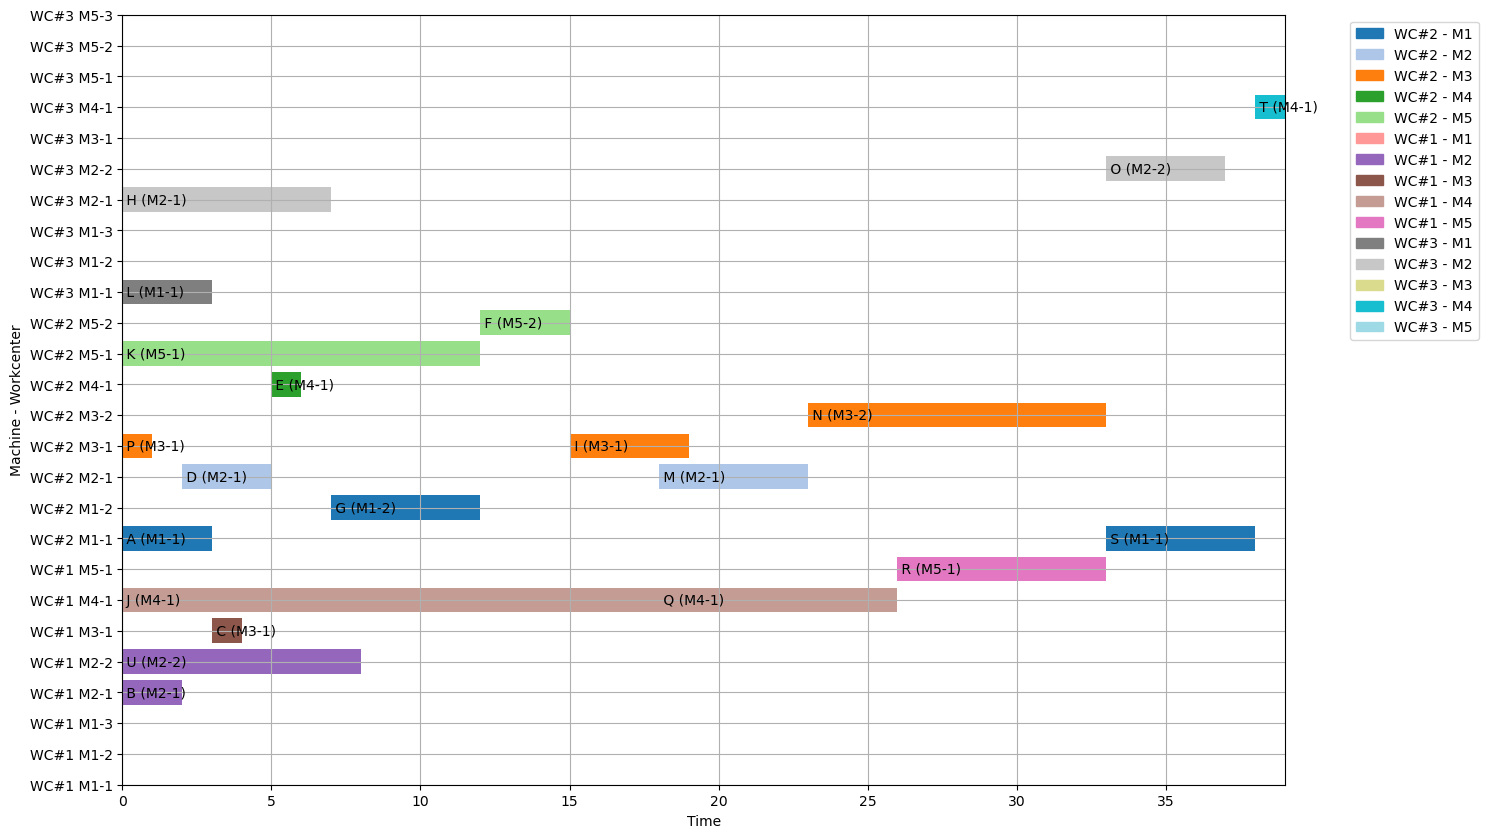

/var/folders/wf/1397g30x0s78k17gwsvbn_lw0000gn/T/ipykernel_84556/1912677217.py:65: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_palette = plt.cm.get_cmap('Pastel1', len(unique_workcenters))


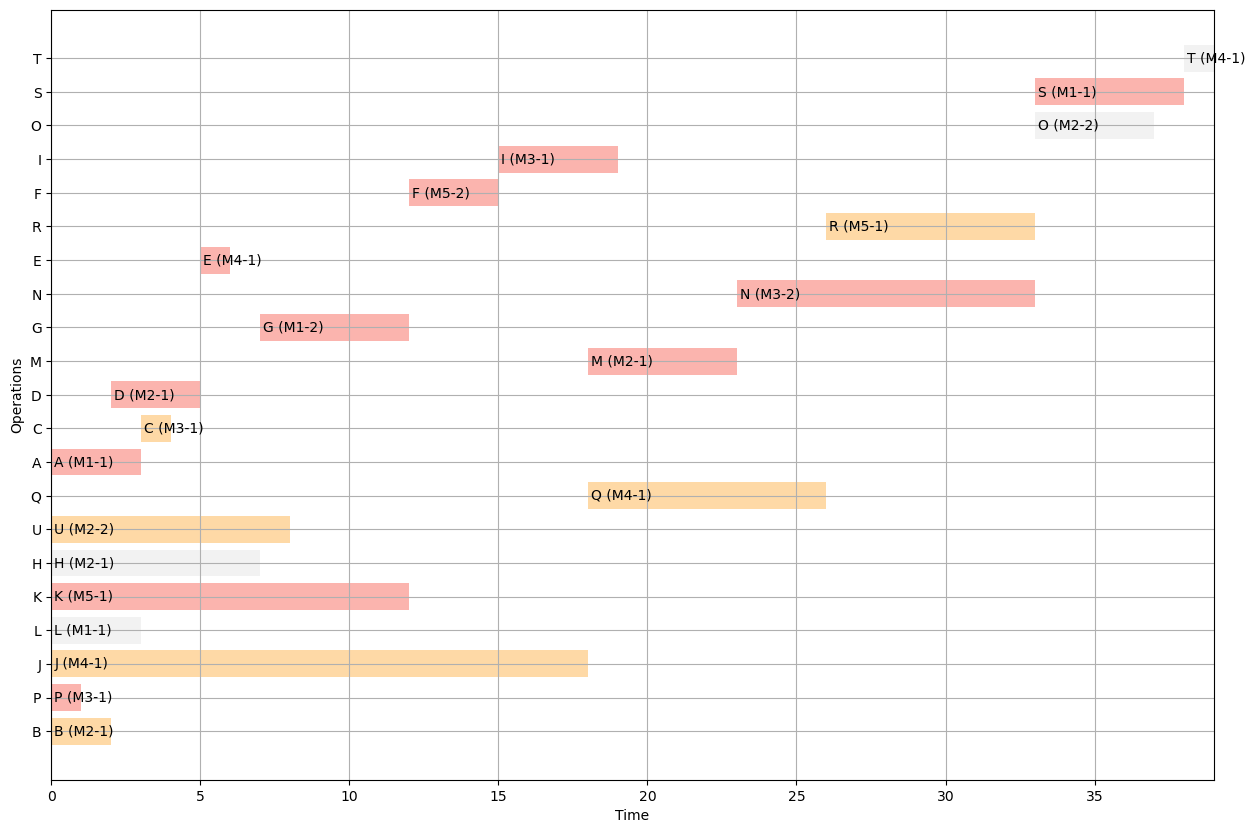

In [11]:
if __name__ == "__main__":
    main()